<a href="https://colab.research.google.com/github/rlberry-py/rlberry/blob/main/notebooks/rlberry_evaluate_and_optimize_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluate an agent and optimize its hyperparameters with `rlberry`

## Colab Setup

In [2]:
from IPython import get_ipython
COLAB = False
if 'google.colab' in str(get_ipython()):
    COLAB = True

if COLAB:
    # install rlberry library
    !git clone https://github.com/rlberry-py/rlberry.git 
    !cd rlberry && git pull && pip install -e .[full] > /dev/null 2>&1

    # install ffmpeg-python for saving videos
    !pip install ffmpeg-python > /dev/null 2>&1

    # install optuna for hyperparameter optimization
    !pip install optuna > /dev/null 2>&1

    # packages required to show video
    !pip install pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    print("")
    print(" ~~~  Libraries installed, please restart the runtime! ~~~ ")
    print("")


## `AgentStats`: training several instances of an agent

The class `AgentStats` can be used to train several instances of an agent (in parallel), optimize its hyperparameters and analyze its performance.

Check the code below to learn how!

[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
[INFO] Training AgentStats for REINFORCE...  


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0INFO: Making new env: CartPole-v0



[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] [REINFORCE] | max_global_step = 395 | episode_rewards = 26.0 |  
[INFO] [REINFORCE] | max_global_step = 389 | episode_rewards = 44.0 |  
[INFO] Sucessful call to AgentHandler.dump() for <class 'rlberry.agents.torch.reinforce.reinforce.REINFORCEAgent'> 
[INFO] Sucessful call to AgentHandler.dump() for <class 'rlberry.agents.torch.reinforce.reinforce.REINFORCEAgent'> 
[INFO] ... trained! 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] Sucessful call to AgentHandler.load() for <class 'rlberry.agents.torch.reinforce.reinforce.REINFORCEAgent'> 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] Sucessful call to AgentHandler.load() for <class 'rlberry.agents.torch.reinforce.reinforce.REINFORCEAgent'> 


INFO: Making new env: CartPole-v0
INFO: Making new env: CartPole-v0


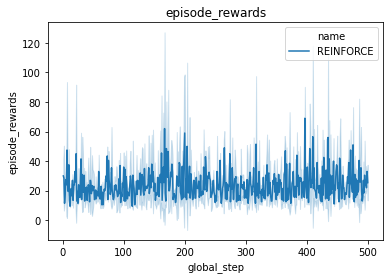

In [3]:
from rlberry.envs import gym_make
from rlberry.agents.torch.reinforce import REINFORCEAgent
from rlberry.stats import AgentStats, plot_writer_data


# Environment
env_ctor = gym_make
env_kwargs = dict(id='CartPole-v0')
env = env_ctor(**env_kwargs)

# Initial set of parameters
params = dict(
    gamma=0.99,
    horizon=200
)

# Create AgentStats to fit 2 instances of REINFORCE in parallel.
stats = AgentStats(REINFORCEAgent,
                   (env_ctor, env_kwargs),
                   fit_budget=500,   # number of episodes
                   init_kwargs=params,
                   eval_kwargs=dict(eval_horizon=200),
                   n_fit=2,
                   parallelization='thread')

# Fit the 4 instances
stats.fit()

# The fit() method of REINFORCEAgent writes data to a DefaultWriter (rlberry.utils.writer)
# object, which can be plotted with the method below.
plot_writer_data(stats, tag='episode_rewards')

## `AgentStats`: optimizing hyperparameters

The agent was not able to learn with the previous set of hyperparameters. Let's see if we can make it work by optimizing these parameters!

`REINFORCEAgent` implements a method `sample_hyperparameters`, which allows `AgentStats` to search for the best configuration of hyperparameters. In the class `REINFORCEAgent`, we have:

```python
@classmethod
def sample_parameters(cls, trial):
    """
    Sample hyperparameters for hyperparam optimization using
    Optuna (https://optuna.org/)

    Note: only the kwargs sent to __init__ are optimized. Make sure to
    include in the Agent constructor all "optimizable" parameters.

    Parameters
    ----------
    trial: optuna.trial
    """
    batch_size = trial.suggest_categorical('batch_size', [1, 4, 8, 16, 32])
    gamma = trial.suggest_categorical('gamma', [0.9, 0.95, 0.99])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
    entr_coef = trial.suggest_loguniform('entr_coef', 1e-8, 0.1)

    return {
            'batch_size': batch_size,
            'gamma': gamma,
            'learning_rate': learning_rate,
            'entr_coef': entr_coef,
            }
```


In [4]:
# Run optimization and print results
stats.optimize_hyperparams(
    n_trials=100,
    timeout=120,   # stop after 120 seconds
    n_fit=1,
    sampler_method='optuna_default'
)

print(stats.best_hyperparams)

# Calling fit() again will train the agent with the optimized parameters
stats.fit()
plot_writer_data(stats, tag='episode_rewards')

Connected to stats_REINFORCE_1629905927/data_1406960173434401629905927.db (sqlite3 version = 2.6.0)


[I 2021-08-25 17:38:52,384] A new study created in RDB with name: no-name-fb1034e1-a159-4111-a761-8deabf3a8794
[INFO] Training AgentStats for optim...  
[I 2021-08-25 17:39:10,590] Trial 0 finished with value: 200.0 and parameters: {'batch_size': 8, 'gamma': 0.9, 'learning_rate': 0.03366857237157537, 'entr_coef': 6.0851176921652164e-05}. Best is trial 0 with value: 200.0.
[I 2021-08-25 17:39:15,646] Trial 1 finished with value: 37.6 and parameters: {'batch_size': 16, 'gamma': 0.99, 'learning_rate': 0.0014898752406096612, 'entr_coef': 0.0015700208203893891}. Best is trial 0 with value: 200.0.
[I 2021-08-25 17:39:18,826] Trial 2 finished with value: 20.1 and parameters: {'batch_size': 8, 'gamma': 0.99, 'learning_rate': 1.447534957120886e-05, 'entr_coef': 4.4609016243447855e-08}. Best is trial 0 with value: 200.0.
[I 2021-08-25 17:39:23,252] Trial 3 finished with value: 29.0 and parameters: {'batch_size': 1, 'gamma': 0.99, 'learning_rate': 6.792133136302428e-05, 'entr_coef': 0.00028436909

{'batch_size': 8, 'entr_coef': 6.0851176921652164e-05, 'gamma': 0.9, 'learning_rate': 0.03366857237157537}
INFO: Making new env: CartPole-v0INFO: Making new env: CartPole-v0



[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


RuntimeError: Unable to handle autograd's threading in combination with fork-based multiprocessing. See https://github.com/pytorch/pytorch/wiki/Autograd-and-Fork

In [ ]:
# Visualize the agent

import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video
from gym.wrappers import Monitor

# wrap env
env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)

# take one of the trained agents
agent = stats.fitted_agents[0]

for episode in range(1):
    done = False
    state = env.reset()
    while not done:
        action = agent.policy(state)
        state, reward, done, info = env.step(action)
env.close()
show_video(directory="./gym-results")

INFO: Creating monitor directory ./gym-results
INFO: Starting new video recorder writing to /content/gym-results/openaigym.video.0.2675.video000000.mp4
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/gym-results')


In [ ]:
# clear data
stats.clear_output_dir()